In [1]:
import numpy as np
import scipy.integrate
import scipy as sp
import matplotlib.pyplot as plt
from numpy import sqrt
from numpy.linalg import norm
import scipy.io as scio
from scipy import interpolate

In [2]:
# Select hyperparams
opt = "Rad" # prior
init_type = 2 # PCA init or informative init
spectrum = "MP"

if spectrum == "real data":
    outlier_num = 8
    data=scio.loadmat('cov1.mat')
    cov=data['cov']
    d_noise,UZ = np.linalg.eig(cov)
    d_noise_sort = -np.sort(-d_noise)
    eig_max = d_noise_sort[outlier_num-1]  # substract the top 8 outlier
    posit = abs(d_noise)<eig_max;
    d_noise[~posit] = 0;
    mean_d = np.mean(d_noise)
    d_noise = d_noise - mean_d
    cov = UZ@np.diag(d_noise)@UZ.T

    cov = (cov+cov.T)/2 # keep the matrix symmetry, avoid numerical accuracy issues
    cov = cov/np.linalg.norm(cov,'fro')*np.sqrt(np.size(cov,1)) # scale the variance = 1

    d_noise,UZ = np.linalg.eig(cov)

    # fit the spectrum
    temp=plt.hist(d_noise,100,density=True)
    prob,bins=temp[0],temp[1]
    xList = bins[:-1] + (bins[1]-bins[0])/2

    rho = interpolate.interp1d(xList, prob, fill_value=(0),bounds_error=False) 
    plt.plot(xList,rho(xList))
    print(sp.integrate.quad(rho,-3,3)[0])

    interval = 0.05
    problist = []
    for x in xList:
        problist.append(np.sum((d_noise>(x-interval/2))*(d_noise<(x+interval/2)))/len(d_noise)/interval)

    lam = 3
    xmin,xmax = -3,3 #boundary of the spectrum

elif spectrum == "sesetic":
    lam=1.8
    xi=27./80
    a=np.sqrt(2./3.)
    xmin,xmax=-2*a,2*a
    def rho(x):
        a=(1/(10*xi))**(1/6) 
        return (6*a**4*xi+2*a**2*x**2*xi+xi*x**4)*np.sqrt(4*a**2-x**2)/(2*np.pi) 
    
elif spectrum == "quartic":
    lam=1.8
    mu=0.5
    gamma=1/27*(8-9*mu+np.sqrt(64-144*mu+108*mu**2-27*mu**3))
    a=np.sqrt((np.sqrt(mu**2+12*gamma)-mu)/(6*gamma))
    xmin,xmax=-2*a,2*a
    def rho(x):
        res=(mu+2*gamma*a**2+gamma*x**2)*np.sqrt(4*a**2-x**2)/(2*np.pi)
        return np.nan_to_num(res)
    
elif spectrum == "pure quartic":
    lam=1.8
    mu=0
    gamma=1/27*(8-9*mu+np.sqrt(64-144*mu+108*mu**2-27*mu**3))
    a=np.sqrt((np.sqrt(mu**2+12*gamma)-mu)/(6*gamma))
    xmin,xmax=-2*a,2*a
    def rho(x):
        res=(mu+2*gamma*a**2+gamma*x**2)*np.sqrt(4*a**2-x**2)/(2*np.pi)
        return np.nan_to_num(res)
    
elif spectrum == "MP":
    lam=0.9
    q=0.2
    xmin=(1-np.sqrt(q))**2
    xmax=(1+np.sqrt(q))**2
    def rho(x):
        res=np.sqrt((xmax-x)*(x-xmin))/2/np.pi/q/x
        return np.nan_to_num(res)

elif spectrum == "normal":
    from scipy import stats
    lam = 1.6
    init_type = 1
    xmin = -5
    xmax = 5
    rho_original = lambda x: stats.norm.pdf(x, 0, 1)
    normalization=sp.integrate.quad(rho_original,xmin,xmax)[0]
    rho = lambda x: np.select([(np.array(x)<xmin)+(np.array(x)>xmax), (np.array(x)>=xmin)*(np.array(x)<=xmax)], [0, rho_original(x)/normalization])

else: 
    raise NotImplementedError

/tmp/ipykernel_4010/3392553321.py:76: RuntimeWarning: invalid value encountered in sqrt
  res=np.sqrt((xmax-x)*(x-xmin))/2/np.pi/q/x


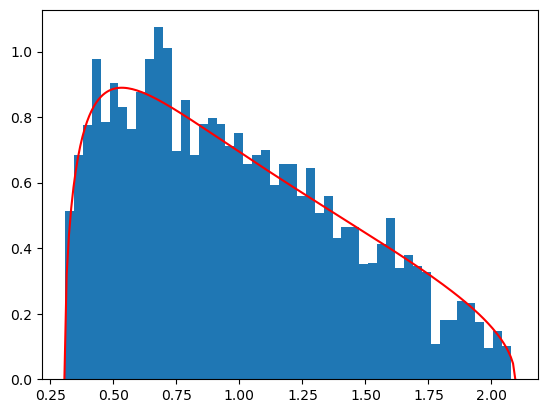

In [3]:
#Sampler to create spectrum, composed by iid samples
def metropolis_sampler(p, nsamples):
    x = (xmin+xmax)/2 # start somewhere

    for i in range(nsamples):
        trial = x+np.random.uniform(-1,1) # random neighbour from the proposal distribution
        acceptance = p(trial)/p(x)

        # accept the move conditionally
        if np.random.uniform() < acceptance:
            x = trial
        yield x


#a small check
samples = list(metropolis_sampler(rho, 5000))
num_bins = 50
n, bins, patches = plt.hist(samples, num_bins, density=True)
x=np.linspace(xmin,xmax,200)
plt.plot(x,rho(x),'r-')

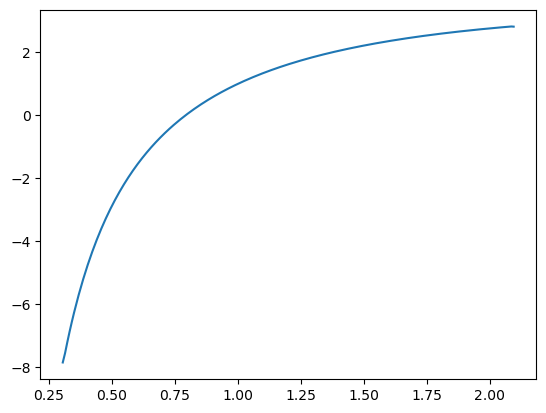

In [4]:
from scipy import interpolate

# calculate V' by Hilbert transform and interpolation
def calculate_Vprime(rho,lambda1,lambda2):
    d0=10000
    x=np.linspace(lambda1,lambda2,d0)
    V=scipy.signal.hilbert(np.concatenate([np.zeros(d0,),rho(x),np.zeros(d0,)]), N=None)*2*np.pi
    return  interpolate.interp1d(x, np.imag(V)[d0:2*d0], fill_value='extrapolate') 

x=np.linspace(xmin,xmax,200)
Vprime=calculate_Vprime(rho,xmin,xmax)
plt.plot(x,Vprime(x))
plt.show()

In [5]:
d=1000

# calculate the preprocessing function J
def preJ_eig(input,lam):
    Vprime=calculate_Vprime(rho,xmin,xmax)
    x1=np.linspace(xmin-0.01,xmax+0.01,d).reshape((-1,1))
    x2=np.linspace(xmin,xmax,d).reshape((-1,1))
    dx=(xmax-xmin)/d
    derivatives=(Vprime(x1)-Vprime(x2).T)/(x1-x2.T)
    res=lam*Vprime(x1)-lam**2*np.sum(rho(x2.T)*derivatives,axis=1,keepdims=True)*dx
    return np.interp(input, x1.reshape(-1), res.reshape(-1))

In [6]:
#simple dichotomy to find zeroes of functions
def bisection(func,x_1,x_2,precision=32):
    for i in range(precision):
      m=(x_1+x_2)/2
      fm=func(m)
      if fm<0:
        x_2=m
      else:
        x_1=m
    return (x_1+x_2)/2

def R_transform(input,rho,lam,xmin,xmax):
   x=np.linspace(xmin,xmax,100000).reshape((-1,1))
   dx=(xmax-xmin)/100000
   func = lambda z: np.sum(rho(x).T/(z-preJ_eig(x,lam).T)*dx,axis=1)-input
   z1 = max(preJ_eig(x,lam))+0.001
   z2 = max(preJ_eig(x,lam))+10000
   if func(z1)<0:
        return z1-1/input
   elif func(z2)>0:
        return z2-1/input
   return bisection(func,z1,z2)-1/input

In [7]:
def replica_SE(R,m_init,opt,r=0.3):
    m_old=m_new=m_init
    
    crit=1
    conv=1e-3
    # conv=1e-6
    it=1
    while crit>conv and it<200:
      print("m:",m_new)
      hat_m=-R(1-m_new)
      print("hat_m:",hat_m)

      if hat_m<0:
        print("numerical error: hat_m<0!")
        return m_new
      
      #below we offer a choice among three different priors
      m_old=m_new
      #Rademacher prior
      if opt=='Rad':
        m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_m)+hat_m),-15,15)[0]


      #GAUSSIAN PRIOR
      if opt=="Gauss":
        m_new=hat_m/(1+hat_m)

      #sparse prior, only case in which "r" plays a role
      if opt=='sparse':
        aux=lambda X: X*sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/np.sqrt(2*np.pi)*np.sqrt(r)*np.sinh((Z*np.sqrt(hat_m)+hat_m*X)/np.sqrt(r))*np.exp(-hat_m/(2*r))/(1-r+r*np.cosh((Z*np.sqrt(hat_m)+hat_m*X)/np.sqrt(r))*np.exp(-hat_m/(2*r))),-15,15)[0]
        m_new=r/2*(aux(-1/np.sqrt(r))+aux(1/np.sqrt(r)))+(1-r)*aux(0)
      
      crit=np.abs(m_old-m_new)
      it+=1
    return m_new

In [8]:
m_initial=0.8
m=replica_SE(lambda x:R_transform(x,rho,lam,xmin,xmax),m_initial,opt)

m: 0.8
hat_m: [2.47761519]
m: 0.8288509258424218


/tmp/ipykernel_4010/2126598316.py:21: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_m)+hat_m),-15,15)[0]


hat_m: [2.6892127]
m: 0.8497774466188595
hat_m: [2.85922454]
m: 0.864595885235585
hat_m: [2.98948545]
m: 0.8748885243743335
hat_m: [3.08540748]
m: 0.8819328134626871
hat_m: [3.15387185]
m: 0.8867018686385211
hat_m: [3.20160667]
m: 0.8899056069424948
hat_m: [3.23433004]
m: 0.8920462138668703
hat_m: [3.25649774]
m: 0.8934712130451289
hat_m: [3.27139275]


In [9]:
#generate observations
def generator(N,Z,lam,opt):
    if opt=="Rad":
      X=np.sign(np.random.randn(N))
    elif opt=="Gauss":
      X=np.random.randn(N)
    elif opt=="sparse":
      r=0.3
      X=np.sign(np.random.randn(N))*1/np.sqrt(r)
      p=np.random.uniform(0,1,N)
      X*=(p>1-r)
    else:
      raise NotImplementedError
    spike=np.outer(X,X)
    Y=lam/N*spike+Z
    return Y, Y*(np.ones((N,N))-np.identity(N)),X

if spectrum == "real data":
    N=len(cov)
    Y,S,X=generator(N,cov,lam,opt)

else:
  #build noise
  N=2000

  Z=np.random.randn(N,N)
  Z=(Z+Z.transpose())/sqrt(2*N)
  D,O=np.linalg.eig(Z)

  noisediag=list(metropolis_sampler(rho, N))
  D=np.diag(np.array(noisediag))
  Z=np.dot(O,np.dot(D,O.transpose()))

  Y,S,X=generator(N,Z,lam,opt)

/tmp/ipykernel_4010/3392553321.py:76: RuntimeWarning: invalid value encountered in sqrt
  res=np.sqrt((xmax-x)*(x-xmin))/2/np.pi/q/x


In [10]:
def denoiser(a,b,opt):
    if opt=="Rad":
        return np.tanh(a)
    elif opt=="Gauss":
        return a/(b+1)
    elif opt=="sparse":
        r=0.3
        return np.sqrt(r)*np.sinh(a/np.sqrt(r))*np.exp(-b/(2*r))/(1-r+r*np.cosh(a/np.sqrt(r))*np.exp(-b/(2*r)))
    else:
        raise NotImplementedError
    
def AMP(S,N,X,m,damp,R,conv,opt,x_init,eps=0.9):
    if x_init is None:
        x=sqrt(eps)*X+sqrt(1-eps)*np.random.randn(N)
        x_old=np.zeros((N))
    else:
        x_old=x=x_init

    it=0
    crit=conv+1
    MSE=[]
    Onsager_coefficent=R(1-m)
    while it<200:
      # MSE.append(norm(x*np.sign(X.T@x)-X)**2/norm(X)**2) # MSE of x
      MSE.append(norm(np.outer(x,x)-np.outer(X,X))**2/N**2) # MSE of xx^T
      onsager=Onsager_coefficent*x_old
      A=np.dot(S,x)-onsager
      if opt=="Rad":
        x_new=np.tanh(A)
      else:
        x_new=denoiser(A,-R(1-np.mean(x_old**2)),opt)
      x_old=x
      x=(1-damp)*x_new+damp*x
      crit=norm(x-x_old)**2/N
      it=it+1
    overlap=np.dot(np.transpose(x),X)/N
    print('empirical=',overlap/norm(x/N)/norm(X),'theoretical=',m,it,crit)
    print('MSE=',MSE[-1])
    print('MMSE=',1-m**2)
    return x, overlap,it,crit,x_old,MSE

def preJ(Y,lam):
  # calculate J(Y) and the leading eigenvector of Y
  eig,Q = np.linalg.eig(Y)
  eig=np.real(eig)
  new_eig=preJ_eig(eig,lam)

  index = np.argmax(eig)
  return Q@np.diag(new_eig)@Q.T, Q[:,index]/norm(Q[:,index])*np.sqrt(N)


JY,x_init=preJ(Y,lam)
if init_type==1:
    x,overlap,it,crit,x_old,MSE=AMP(JY,N,X,m,damp=0.9,R=lambda x:R_transform(x,rho,lam,xmin,xmax),conv=1.0e-6,opt=opt,x_init=None)
else:
    x,overlap,it,crit,x_old,MSE=AMP(JY,N,X,m,damp=0.9,R=lambda x:R_transform(x,rho,lam,xmin,xmax),conv=1.0e-6,opt=opt,x_init=x_init)
print(norm(x)**2/N,overlap,m)

empirical= -0.9510149247670893 theoretical= 0.8944174970243272 200 9.77094213855417e-08
MSE= 0.18217683211502814
MMSE= 0.20001734101673774
0.8960125416091594 -0.9002111273852063 0.8944174970243272


In [11]:
def repeated_trials(lam,opt):
    m=replica_SE(lambda x:R_transform(x,rho,lam,xmin,xmax),0.9,opt)
    N=2000
    TEST=10
    MSE=[]
    for _ in range(TEST):
        Z=np.random.randn(N,N)
        Z=(Z+Z.transpose())/sqrt(2*N)
        D,O=np.linalg.eig(Z)

        noisediag=list(metropolis_sampler(rho, N))
        D=np.diag(np.array(noisediag))
        Z=np.dot(O,np.dot(D,O.transpose()))

        Y,S,X=generator(N,Z,lam,opt)

        JY,x_init=preJ(Y,lam)
        if init_type==1:
            x,overlap,it,crit,x_old,MSE1=AMP(JY,N,X,m,damp=0.9,R=lambda x:R_transform(x,rho,lam,xmin,xmax),conv=1.0e-6,opt=opt,x_init=None)
        else:
            x,overlap,it,crit,x_old,MSE1=AMP(JY,N,X,m,damp=0.9,R=lambda x:R_transform(x,rho,lam,xmin,xmax),conv=1.0e-6,opt=opt,x_init=x_init)
        MSE.append(MSE1[-1])
    return 1-m**2,MSE

m: 0.9
hat_m: [1.17367535]
m: 0.6015624827891233


/tmp/ipykernel_4010/2126598316.py:21: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_m)+hat_m),-15,15)[0]


hat_m: [0.59480468]
m: 0.3958075161169226
hat_m: [0.35203264]
m: 0.26884264283660103
hat_m: [0.23473631]
m: 0.19362673717667206
hat_m: [0.17364227]
m: 0.14968489024839454
hat_m: [0.14037619]
m: 0.12412418155217744
hat_m: [0.12177434]
m: 0.10927291923596735
hat_m: [0.11120404]
m: 0.10064388045102009
hat_m: [0.10514013]
m: 0.09562911910553637
hat_m: [0.10164281]
m: 0.09271503698206732
hat_m: [0.09962101]
m: 0.09102301559562896
hat_m: [0.0984471]


/tmp/ipykernel_4010/3392553321.py:76: RuntimeWarning: invalid value encountered in sqrt
  res=np.sqrt((xmax-x)*(x-xmin))/2/np.pi/q/x


empirical= 0.09256066140940114 theoretical= 0.09003808408542645 200 3.392721698528003e-07
MSE= 0.9999496389060821
MMSE= 0.9918931434142256
empirical= 0.042504885906552985 theoretical= 0.09003808408542645 200 3.492309630804674e-07
MSE= 1.0001223675083324
MMSE= 0.9918931434142256
empirical= 0.12914976634791356 theoretical= 0.09003808408542645 200 3.0691698534241177e-07
MSE= 0.9997216683140259
MMSE= 0.9918931434142256
empirical= 0.07809236936214377 theoretical= 0.09003808408542645 200 3.4602392025263256e-07
MSE= 1.0000113594355595
MMSE= 0.9918931434142256
empirical= 0.04103538750184573 theoretical= 0.09003808408542645 200 3.4933596750272725e-07
MSE= 1.0001277083225855
MMSE= 0.9918931434142256
empirical= 0.018883284415072494 theoretical= 0.09003808408542645 200 3.462614489893157e-07
MSE= 1.0001696381322642
MMSE= 0.9918931434142256
empirical= 0.14417221585559986 theoretical= 0.09003808408542645 200 2.9692950365279786e-07
MSE= 0.9995754957584654
MMSE= 0.9918931434142256
empirical= -0.1660428

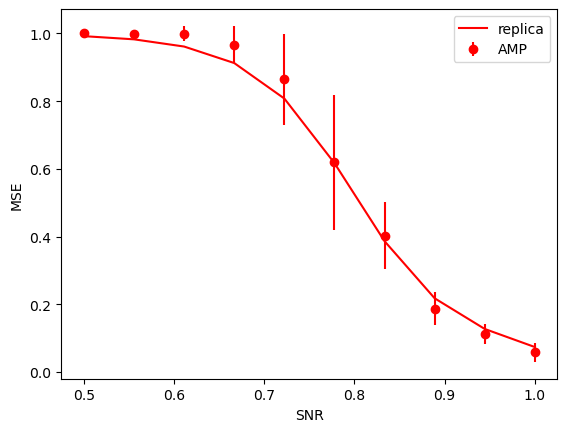

In [12]:
SNR=np.linspace(0.5,1.0,10)
MMSE=[]
MSE=[]
mean_MSE=[]
MSE_std=[]
for lam_test in SNR:
    res=repeated_trials(lam_test,"Rad")
    MMSE.append(res[0])
    MSE.append(res[1])
    mean_MSE.append(np.mean(res[1]))
    MSE_std.append(np.std(res[1]))
    print("SNR=",lam_test,",MMSE=",MMSE[-1],",MSE=",mean_MSE[-1])
    print("finish",len(mean_MSE)/len(SNR))

normalization=np.sqrt(sp.integrate.quad(lambda x: x**2*rho(x),xmin,xmax)[0]-(sp.integrate.quad(lambda x: x*rho(x),xmin,xmax)[0])**2)
plt.plot(SNR,MMSE,color="r",label="replica")
plt.errorbar(SNR,mean_MSE,yerr=MSE_std,color="r",label="AMP",fmt="o")
plt.xlabel("SNR")
plt.ylabel("MSE")
plt.legend()